In [22]:
# Goal: Design simple fit to the absorption line velocity
import sys,os,json
import numpy as np
import astropy.table as table
import matplotlib.pyplot as plt
import george
from george import kernels
import george.modeling as gmodel
import numba
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
from snelib19odp.specds import load_dataset
from snelib19odp.analysis.ejecta_velocity import vHe5876_to_vEpansion, vHe5876_to_vEpansion_disperson
import snelib19odp.absfit as absfit
import astropy.constants as aconst
import astropy.units as u

In [2]:
sds = load_dataset('SN2019odp')

In [3]:
C_KM_S = aconst.c.to(u.km/u.s).value

def load_measurements(sds, entry, rev, line):
    fname = sds.get_absfit_path(entry, fit_rev=rev, line=line)
    if not os.path.isfile(fname):
        # TODO: log a warning?
        return None, None
    
    result = absfit.AbsFitResult.load(fname)

    ret = {}

    # ret['logz'] = result.meta['logz']

    for i,label in enumerate(result.parameter_names):
        q = np.quantile(result.trace[:,i], [0.025, 0.5, 0.975, 0.841, 0.159])
        ret['%s_q2.5' % label] = q[0]
        ret['%s_q50' % label] = q[1]
        ret['%s_q97.5' % label] = q[2]
        ret['%s_q84.1' % label] = q[3]
        ret['%s_q15.9' % label] = q[4]

    # extract velocities
    center_idx = result.parameter_names.index('center')

    velocities = (np.array(result.trace[:,center_idx], dtype=np.float) - line)/line * C_KM_S
    label = 'velocity'
    q = np.quantile(velocities, [0.025, 0.5, 0.975, 0.841, 0.159])
    ret['%s_q2.5' % label] = q[0]
    ret['%s_q50' % label] = q[1]
    ret['%s_q97.5' % label] = q[2]
    ret['%s_q84.1' % label] = q[3]
    ret['%s_q15.9' % label] = q[4]

    # extract emission velocites
    em_center_offset_idx = result.parameter_names.index('center_offset_em')

    velocities = (np.array(result.trace[:,center_idx]+result.trace[:, em_center_offset_idx], dtype=np.float) - line)/line * C_KM_S
    label = 'velocity_em'
    q = np.quantile(velocities, [0.025, 0.5, 0.975, 0.841, 0.159])
    ret['%s_q2.5' % label] = q[0]
    ret['%s_q50' % label] = q[1]
    ret['%s_q97.5' % label] = q[2]
    ret['%s_q84.1' % label] = q[3]
    ret['%s_q15.9' % label] = q[4]
    
    # TODO: extract more interesting params
    
    return ret, velocities

In [4]:
rev = 1

rows = []
#for line,rev in [(5876, 1), (6678, 2), (7065,1)]:
for line,rev in [(5876, 1)]:
    for entry in sds.names:
        measurements,velocities = load_measurements(sds, entry, rev, line)
        if measurements is None:
            continue
        measurements['phase'] = sds[entry].meta['phase']
        measurements['line'] = line
        rows.append(measurements)
dat = table.Table(rows=rows)
dat.sort('phase')
dat

<Table length=28>
  continuum_q2.5     continuum_q50    ...        phase         line
     float64            float64       ...       float64       int64
------------------ ------------------ ... ------------------- -----
18.242269797208778  19.09533134707545 ...  -16.83842824074236  5876
17.346358290412486 19.596244889055555 ... -15.775404259256902  5876
  17.7847330540256 19.154303796170364 ... -15.544725694446242  5876
29.988126204230724  30.94987559993274 ... -13.822287037037313  5876
56.265862484109945  57.31140028694581 ... -11.635756041665445  5876
 62.77843271688586  64.05649369824827 ... -10.828670138886082  5876
 87.52324403550978   91.6139880270114 ...  -8.016772106479038  5876
 106.9786019207272 108.67011631779827 ...  -6.794097222220444  5876
 154.2453997908147   158.954868455836 ...   2.305526620373712  5876
143.44849007846787 147.73950382908203 ...   9.322689814813202  5876
               ...                ... ...                 ...   ...
 33.31966263484506 36.001694521553304 ...   57.08497106481809  5876
29.452032640711657  36.47153312750869 ...   64.14837847222225  5876
 27.77454148080603 30.492805583967318 ...   75.93090408564603  5876
22.925219279572474  25.81514766111517 ...   77.25869212963153  5876
16.935982229077908 21.826959346313142 ...  101.10189005518623  5876
 12.26988165766599 16.761559888361077 ...  104.16555089980102  5876
14.351045976610923 15.203194054462863 ...  118.14001736111095  5876
13.108252719069625 14.112153863038355 ...  127.85248678240896  5876
10.166977303878234 11.069974468251386 ...  138.22917824074102  5876
1.0007916335477174  1.018848750883087 ...   348.4990856481454  5876

In [5]:
class Poly2(gmodel.Model):
    parameter_names = ('x0', 'x1', 'x2')
    
    def get_value(self, x):
        return self.x0 + self.x1*x + self.x2*x*x

poly2_pinit = {
    'x0': 5000,
    'x1': 5,
    'x2': 3
}

@numba.njit
def poly2_prior(u):
    x = np.empty_like(u)
    x[0] = 4e4*u[0]-2e4
    x[1] = 1e3*u[1]-500
    x[2] = 200*u[2]-100
    
    # kernel params
    x[3] = 12*u[3]-7
    x[4] = 6*u[4]-3
    return x



In [6]:
class Exp(gmodel.Model):
    parameter_names = ('t0', 'log_alpha', 'amp')
    
    def get_value(self, x):
        alpha = -np.exp(self.log_alpha)
        return self.amp*(x-self.t0)**alpha

exp_pinit = {
    't0': -10,
    'log_alpha': -0.5,
    'amp': 12e3
}

@numba.njit
def exp_prior(u):
    x = np.empty_like(u)
    x[0] = 50*u[0]-60
    x[1] = 10*u[1]-5
    x[2] = 20e3*u[2] + 1000
    
    # kernel params
    x[3] = 12*u[3]-7
    x[4] = 6*u[4]-3
    return x

In [7]:
idx = dat['phase'] < 30
idx = np.logical_and(idx, dat['amplitude_q2.5'] > 3)
idx = np.logical_and(idx, dat['phase'] > -15.5)
dat2 = dat[idx]
t = dat2['phase']
y = -dat2['velocity_q50']
yerr = np.abs(dat2['velocity_q84.1'] - dat2['velocity_q15.9'])

#gp = george.GP(np.var(y) * kernels.Matern32Kernel(30.0), mean=Poly2(**poly2_pinit))
gp = george.GP(np.var(y) * kernels.Matern32Kernel(30.0), mean=Exp(**exp_pinit))
gp.compute(t, yerr)

In [8]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True)

ndim = len(gp.get_parameter_vector())
#sampler = dynesty.DynamicNestedSampler(lnprob2, poly2_prior, ndim)
sampler = dynesty.DynamicNestedSampler(lnprob2, exp_prior, ndim)
sampler.run_nested()

0it [00:00, ?it/s]<ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
1712it [00:05, 71.26it/s, batch: 0 | bound: 1 | nc: 1 | ncall: 16581 | eff(%): 10.023 | loglstar:   -inf < -76.130 <    inf | logz: -81.507 +/-    nan | dlogz:  8.148 >  0.010]   <ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
2011it [00:06, 205.05it/s, batch: 0 | bound: 2 | nc: 3 | ncall: 17397 | eff(%): 11.237 | loglstar:   -inf < -73.641 <    inf | logz: -78.617 +/-    nan | dlogz:  4.661 >  0.010] <ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
2238it [00:07, 200.67it/s, batch: 0 | bound: 3 | nc: 10 | ncall: 18216 | eff(%): 11.958 | loglstar:   -inf < -72.955 <    inf | logz: -77.778 +/-    nan | dlogz:  3.451 >  0.010]<ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in po

<ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
9254it [01:10, 51.06it/s, batch: 5 | bound: 32 | nc: 1 | ncall: 40806 | eff(%): 22.678 | loglstar: -74.965 < -73.665 < -70.282 | logz: -75.713 +/-    nan | stop:  1.616]<ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
<ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
9491it [01:13, 76.13it/s, batch: 5 | bound: 34 | nc: 1 | ncall: 41584 | eff(%): 22.009 | loglstar: -74.965 < -73.596 < -70.282 | logz: -75.713 +/-    nan | stop:  1.616] <ipython-input-6-ac6fe0529d03>:6: RuntimeWarning: invalid value encountered in power
  return self.amp*(x-self.t0)**alpha
9648it [01:14, 116.90it/s, batch: 5 | bound: 35 | nc: 4 | ncall: 42333 | eff(%): 21.991 | loglstar: -74.965 < -73.175 < -70.282 | logz: -75.713 +/-    nan | stop:  1.616] <i

<ErrorbarContainer object of 3 artists>

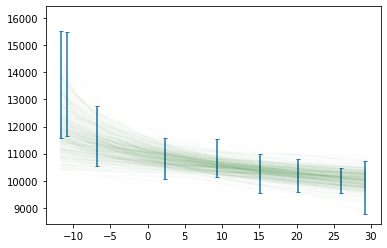

In [9]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
t_grid = np.linspace(t.min(), t.max())
for j,sidx in enumerate(np.random.randint(len(trace), size=300)):
    s = trace[sidx]
    gp.set_parameter_vector(s)
    v = gp.sample_conditional(y, t_grid)
    plt.plot(t_grid, v, alpha=0.01, color='green')
plt.errorbar(t, y, yerr=yerr, ls='', capsize=2)

In [10]:
p = np.polyfit(t, y, 2)
t_grid = np.linspace(t.min(), t.max())
plt.plot(t_grid, np.polyval(p, t_grid))
plt.errorbar(t, y, yerr=yerr, ls='', capsize=2)
p

array([ 2.66469813e+00, -1.26893284e+02,  1.14543010e+04])

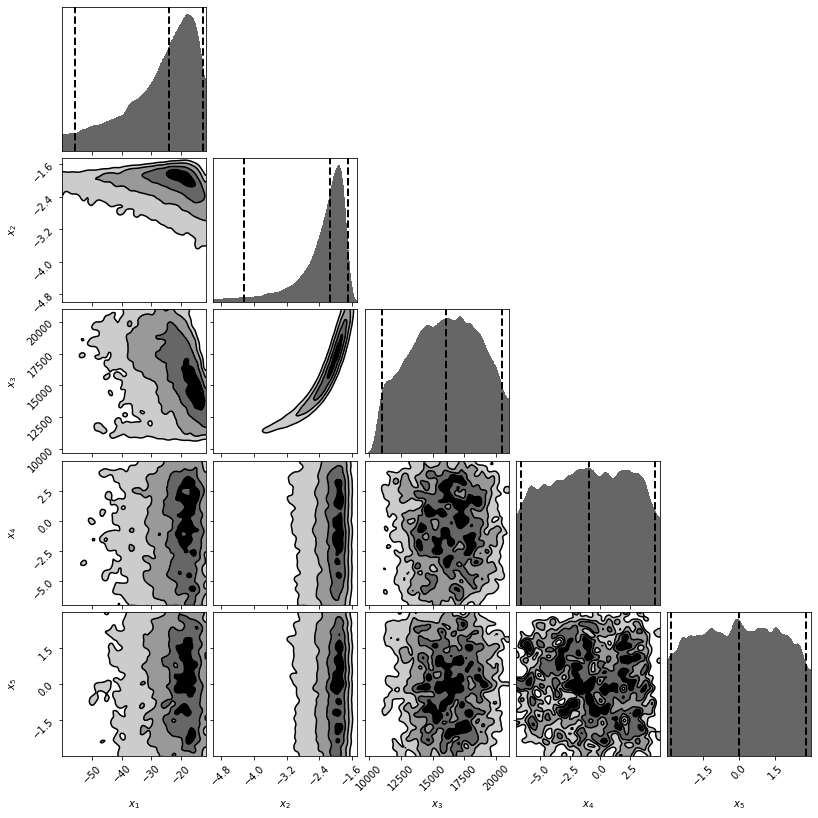

In [11]:
dyplot.cornerplot(results);

In [12]:
gp.get_parameter_names()

('mean:t0',
 'mean:log_alpha',
 'mean:amp',
 'kernel:k1:log_constant',
 'kernel:k2:metric:log_M_0_0')

In [13]:
dat['amplitude_q50']

<Column name='amplitude_q50' dtype='float64' length=28>
0.5501736594410129
 5.989836279226319
 4.772617701001856
5.7175910302903885
 7.685083933145872
  6.23480005683205
 7.326845591520442
 7.836184407087803
 8.398064439850856
 8.386659868442349
 7.854308641246703
 8.057934725257724
               ...
7.9536561129293455
 7.845238742139497
  7.59921937792778
 8.195630965757502
  8.25683287607393
 7.092439632619595
 8.880969644190932
1.5056715660933535
 7.165872242279674
 7.742114569841535
 7.394610611748318
 5.795432413650627

(array([ 724., 1800., 2205., 2771., 3025., 3200., 3220., 3032., 2467.,
        1669.]),
 array([10021.86913329, 11119.37906899, 12216.8890047 , 13314.39894041,
        14411.90887611, 15509.41881182, 16606.92874753, 17704.43868323,
        18801.94861894, 19899.45855465, 20996.96849035]),
 <BarContainer object of 10 artists>)

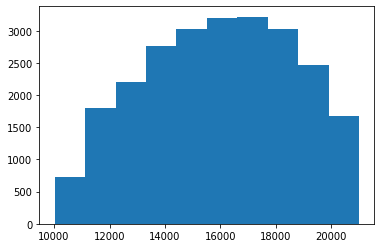

In [14]:
plt.hist(trace[:,2])

In [15]:
#np.nanmean(trace[:,0])
np.nanmean(trace[:,2])

15944.71283857045

In [16]:
#np.nanstd(trace[:,0])
np.nanstd(trace[:,2])

2676.096642643894

In [17]:
def sample(sidx):
    gp.set_parameter_vector(trace[sidx])
    return gp.sample_conditional(y, 0)
samples = np.array(list(map(sample, np.random.randint(len(trace), size=500))))
print(np.nanmean(samples))
print(np.nanstd(samples))
plt.hist(samples);

10977.78314211564
346.94525607459786


In [18]:
r = {
    'mean': np.nanmean(samples),
    'std': np.nanstd(samples)
}
with open('../products/absfit/SN2019odp/peak_he_velocity.txt', 'w') as f:
    json.dump(r, f)
    f.write('\n')

In [24]:
# convert to expansion velocity
def sample(sidx):
    gp.set_parameter_vector(trace[sidx])
    return gp.sample_conditional(y, 0)
samples = np.array(list(map(sample, np.random.randint(len(trace), size=500))))
expansion_velocity = vHe5876_to_vEpansion(samples)
expansion_velocity_mean = np.mean(expansion_velocity)
expansion_velocity_std = np.sqrt(np.std(expansion_velocity)**2 + vHe5876_to_vEpansion_disperson**2)
print(expansion_velocity_mean)
print(expansion_velocity_std)
r = {
    'mean': expansion_velocity_mean,
    'std': expansion_velocity_std,
    'method': 'HeI 5876::Dessart+2016'
}
with open('../products/expansion_velocity.json', 'w') as f:
    json.dump([r], f)
    f.write('\n')

10910.891699200709
1445.3802068496043
